In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

In [2]:
np.version.version

'1.26.4'

### Check for MFCC features

In [ ]:
# pkl file
file_path_mfcc = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_60_cnn.pkl'


def inspection(num, element):
    print(f"Type of the {num} element: {type(element)}")
    print(f"Shape of the {num} element: {(element).shape}")
          
    if isinstance(element, np.ndarray):
        print(f"Length of the {num} inner list: {len(element)}")
        if len(element) > 0:
            print(f"Type of the first item in the {num} inner list: {type(element[0])}")
            print(f"Shape of the first item in the {num} inner list: {(element[0]).shape}")
            print(f"Value of the first item in the {num} inner list: {element[0]}") # Be cautious if it's very large
    elif hasattr(element, 'shape') and hasattr(element, 'dtype'): # Check for NumPy array
        print(f"It looks like a NumPy array with shape: {element.shape} and dtype: {element.dtype}")
    else:
        print(f"Value of the first element (first 100 chars): {str(element)[:100]}")


try:
    if not os.path.exists(file_path_mfcc):
        print(f"Error: The file was not found at {file_path_mfcc}")
    else:
        loaded_df = pd.read_pickle(file_path_mfcc)
        #loaded_df = pd.read_parquet(file_path, engine='pyarrow')

        print(f"Successfully loaded DataFrame from: {file_path_mfcc}")

        if isinstance(loaded_df, list):
            print(f"Length of the main list: {len(loaded_df)}")

        if isinstance(loaded_df, list) and len(loaded_df) > 0:
            print(f"\n--- Inspecting the first three elements ---")
            element_one = loaded_df[0]
            inspection("first",element_one)
            element_two = loaded_df[1]
            inspection("second",element_two)
            element_three = loaded_df[2]
            inspection("third",element_three)
                    

except Exception as e:
    print(f"An error occurred while loading or inspecting the DataFrame: {e}")


Successfully loaded DataFrame from: C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_60_cnn.pkl
Length of the main list: 24844

--- Inspecting the first three elements ---
Type of the first element: <class 'numpy.ndarray'>
Shape of the first element: (60, 224)
Length of the first inner list: 60
Type of the first item in the first inner list: <class 'numpy.ndarray'>
Shape of the first item in the first inner list: (224,)
Value of the first item in the first inner list: [-529.3246   -391.1469   -239.86996  -173.38402  -166.44449  -203.8063
 -289.83777  -168.15309   -87.389946  -87.18621  -127.18453  -200.15901
 -370.41635  -530.3893   -283.88864  -163.41824  -146.59563  -198.26009
 -227.36642  -226.84964  -259.9828   -326.85992  -274.01553  -194.84137
 -208.6496   -234.49873  -236.4428   -272.5793   -331.40933  -354.5592
 -366.19144  -381.30573  -405.83096  -443.81894  -520.37714  -535.34717
 -540.6975   -542.00555  -373.87482  -218.11151  -176.02014  -232.79623
 -404.20224  

In [ ]:
file_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_train.pkl'

loaded_df = pd.read_pickle(file_path)
print(loaded_df['PITCH'][0].shape)

(247,)


### Transform pkl file into parquet file & flatten HNR

In [25]:
def flatten_list_of_scalar_lists(nested_item):
    """
    Converts a list of single-element lists/arrays (e.g., [[-200.0], [-100.0]])
    into a flat list of scalars (e.g., [-200.0, -100.0]).
    It can also handle items that are already scalars within the outer list.
    """
    if not isinstance(nested_item, np.ndarray):
        # If the input isn't a list at all, return np.nan or an empty list
        # depending on how you want to handle unexpected row data.
        return np.nan  # Or: return []

    flat_list = []
    for sub_item in nested_item:
        if isinstance(sub_item, (list, np.ndarray)) and len(sub_item) == 1:
            element = sub_item[0]
            if isinstance(element, (int, float, np.number)):
                flat_list.append(element)
            else:
                # The single element is not a number, append nan
                flat_list.append(np.nan)
        else:
            flat_list.append(np.nan) # Mark as unable to extract a scalar

    flat_array = np.array(flat_list)
    return flat_array

# example_hnr_row = [[-200.0], [-200.0], [-200.0], [-200.0], [-200.0]]
# flattened_result = flatten_list_of_scalar_lists(example_hnr_row)
# print(f"Original: {example_hnr_row}")
# print(f"Flattened: {flattened_result}")


### Adding labels to prosody dataframe

In [33]:
def process(feature_file, label_path):
    label_map = {}
    attack_map = {}
    with open(label_path,'r') as f:
        for line in f:
            parts = line.strip().split()
            audio_id = parts[1]
            attack_type = parts[-2]
            label_str = parts[-1]

            # create dict for labels
            if label_str == 'bonafide':
                label_map[audio_id] = 1
            if label_str == 'spoof':
                label_map[audio_id] = 0
            
            # create dict for attack types
            attack_map[audio_id] = attack_type

    # apply HNR flatten
    feature_df = pd.read_pickle(feature_file)
    feature_df['HNR'] = feature_df['HNR'].apply(flatten_list_of_scalar_lists)
    
    # feature_df = pd.read_parquet(feature_file, engine='pyarrow')
    feature_df['LABEL'] = feature_df['AUDIO_ID'].map(label_map)     # add labels to df
    feature_df['ATTACK_TYPE'] = feature_df['AUDIO_ID'].map(attack_map)  # add attack types to df

    # drop the rows where there is no label
    feature_df = feature_df.dropna(subset=['LABEL'])

    # inspect the new dataframe
    print(feature_df.head())
    print(feature_df.tail())
    print(feature_df.info())
    print(feature_df.describe())

    return feature_df

In [34]:
feature_train_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_train.pkl'
feature_dev_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_dev.pkl'
feature_eval_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_eval.pkl'

label_train_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'
label_dev_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
label_eval_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.eval.trl.txt'

In [ ]:
processed_train = process(feature_train_path, label_train_path)
processed_train.to_parquet(r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_train_wlabel.parquet')

       AUDIO_ID                                              PITCH  \
0  LA_T_1000137  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  LA_T_1000406  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  LA_T_1000648  [nan, nan, nan, nan, nan, 263.08241940297097, ...   
3  LA_T_1000824  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  LA_T_1001074  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

    AVE_PITCH  STD_PITCH                                                HNR  \
0  129.703246  19.223900  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
1  151.166201  18.754230  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
2  240.929243  14.829958  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
3  106.986026  14.755938  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
4  194.306253  54.477061  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   

      AVE_HNR     STD_HNR                                             JITTER  \
0  -92.736529  104.78668

In [ ]:
processed_dev = process(feature_dev_path, label_dev_path)
processed_dev.to_parquet(r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_dev_wlabel.parquet')

       AUDIO_ID                                              PITCH  \
0  LA_D_7341689  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  LA_D_9918902  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  LA_D_1275044  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  LA_D_4897222  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  LA_D_5631993  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

    AVE_PITCH  STD_PITCH                                                HNR  \
0  213.615570  65.016144  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
1  119.354940  15.630035  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
2  193.024226  19.904811  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
3  115.460326  11.565823  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
4  120.441340  49.403521  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   

      AVE_HNR     STD_HNR                                             JITTER  \
0 -113.104043  104.98917

In [36]:
print(processed_dev['LABEL'].hasnans)

False


In [ ]:
processed_eval = process(feature_eval_path, label_eval_path)
processed_eval.to_parquet(r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_eval_wlabel.parquet')

       AUDIO_ID                                              PITCH  \
0  LA_E_2169831  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  LA_E_9534923  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  LA_E_8832198  [nan, nan, nan, nan, nan, 593.6812604851642, 5...   
3  LA_E_6890294  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  LA_E_5780214  [nan, nan, nan, nan, nan, nan, nan, 245.574731...   

    AVE_PITCH  STD_PITCH                                                HNR  \
0   95.383667  40.186379  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
1  116.153108  16.377467  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
2  193.605533  62.519422  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
3  103.660462  14.685025  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   
4  192.215761  43.654432  [-200.0, -200.0, -200.0, -200.0, -200.0, -200....   

      AVE_HNR     STD_HNR                                             JITTER  \
0 -121.409245  101.84415

In [38]:
print(processed_eval['LABEL'].hasnans)

False


### Check if the order of MFCC features matches with that of dataframe

In [23]:
mfcc_label_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_60_cnn_label.pkl'
mfcc_labels = pd.read_pickle(mfcc_label_path)
print(f"The dtype of the file is {type(mfcc_labels)}")
print(f"The dtype of the file is {type(mfcc_labels[0])}")
for i, line in enumerate(mfcc_labels):
    print(f"The {i+1}th element in the file is {line}")
    if i == 10: break

The dtype of the file is <class 'list'>
The dtype of the file is <class 'int'>
The 1th element in the file is 1
The 2th element in the file is 0
The 3th element in the file is 0
The 4th element in the file is 0
The 5th element in the file is 0
The 6th element in the file is 0
The 7th element in the file is 0
The 8th element in the file is 0
The 9th element in the file is 0
The 10th element in the file is 0
The 11th element in the file is 0


In [ ]:
train_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_train_wlabel.parquet'
data_frame_labels = pd.read_parquet(train_path, engine="pyarrow")
df_labels = data_frame_labels["LABEL"]
df_labels_ls = df_labels.to_list()
print(df_labels_ls[:10])
print(df_labels_ls == mfcc_labels)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
False


### Restructure MFCC into a dataframe (id, mfcc)

In [2]:
# --- Step 1: The Foundation - Our Lazy Generator ---
# This function reads one file at a time from disk.
def mfcc_generator(file_ids, mfcc_folder):
    """
    A generator that yields one MFCC at a time.
    """
    for file_id in file_ids:
        file_path = os.path.join(mfcc_folder, f"{file_id}.npy")
        if os.path.exists(file_path):
            mfcc_array = np.load(file_path)
            # Yield a dictionary, which is easy to work with.
            yield {'AUDIO_ID': file_id, 'MFCC': mfcc_array}

In [3]:
def process_mfcc_files(input_path, output_path):
    # --- Step 2: Setup the Batch Processing Loop ---

    # --- Inputs ---
    all_files = os.listdir(input_path)
    ids = [os.path.splitext(f)[0] for f in all_files if f.endswith('.npy')]

    # --- Outputs ---
    os.makedirs(output_path, exist_ok=True)

    # --- Configuration ---
    batch_size = 2000 
    generator = mfcc_generator(ids, input_path)

    chunk = []
    chunk_number = 1

    print(f"Starting processing. Will save data in chunks of {batch_size}.")

    # --- Step 3: The Main Loop ---
    for data_item in generator:
        # Add the loaded item to our current chunk
        chunk.append(data_item)
        
        # When the chunk is full, process and save it
        if len(chunk) == batch_size:
            chunk_df = pd.DataFrame(chunk)
            print(f"  - Processing chunk {chunk_number} (size: {len(chunk)})...")
            
            # --- YOUR PROCESSING LOGIC GOES HERE ---
            # For example, you could apply scaling or any other function to each 'mfcc' in the chunk.
            # For this demo, we'll just save it as is.
            # -----------------------------------------
            
            # Save the processed chunk to a new file
            output_filename = os.path.join(output_path, f"chunk_{chunk_number}.pkl")
            with open(output_filename, 'wb') as f:
                pickle.dump(chunk_df, f)
            print(f"  - Saved {output_filename}")
            
            # Reset for the next chunk
            chunk = []
            chunk_number += 1

    # --- Step 4: Handle the Final, Incomplete Chunk ---
    # After the loop finishes, there might be leftover items.
    if chunk:
        print(f"  - Processing final chunk {chunk_number} (size: {len(chunk)})...")
        chunk_df = pd.DataFrame(chunk)
        # --- YOUR PROCESSING LOGIC GOES HERE ---
        
        output_filename = os.path.join(output_path, f"chunk_{chunk_number}.pkl")
        with open(output_filename, 'wb') as f:
            pickle.dump(chunk_df, f)
        print(f"  - Saved {output_filename}")

    print("\nBatch processing complete!")

In [5]:
mfcc_train_in = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_60\mfcc_train_60"
mfcc_dev_in = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_60\mfcc_dev_60"
mfcc_train_out = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks"
mfcc_dev_out = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks"

In [4]:
mfcc_eval_in = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_60\mfcc_eval_60'
mfcc_eval_out = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks"

In [5]:
process_mfcc_files(mfcc_eval_in, mfcc_eval_out)

Starting processing. Will save data in chunks of 2000.
  - Processing chunk 1 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_1.pkl
  - Processing chunk 2 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_2.pkl
  - Processing chunk 3 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_3.pkl
  - Processing chunk 4 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_4.pkl
  - Processing chunk 5 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_5.pkl
  - Processing chunk 6 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_6.pkl
  - Processing chunk 7 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_7.pkl
  - Processing chunk 8 (size: 2000)

In [6]:
# inspect the dataframe 
inspect = pd.read_pickle(r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_chunks\chunk_1.pkl")
print(inspect.head())
print(inspect.info())
print(inspect['MFCC'][0].shape)

       AUDIO_ID                                               MFCC
0  LA_E_1000147  [[-464.51468, -257.86365, -130.41711, -67.7112...
1  LA_E_1000273  [[-536.5208, -552.54047, -419.27435, -223.4209...
2  LA_E_1000791  [[-488.60654, -278.21362, -183.99652, -160.356...
3  LA_E_1000841  [[-522.5077, -275.63226, -155.25647, -124.8557...
4  LA_E_1000989  [[-505.41733, -204.76515, -87.91863, -40.62164...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AUDIO_ID  2000 non-null   object
 1   MFCC      2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None
(60, 100)


In [6]:
process_mfcc_files(mfcc_train_in, mfcc_train_out)

Starting processing. Will save data in chunks of 2000.
  - Processing chunk 1 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_1.pkl
  - Processing chunk 2 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_2.pkl
  - Processing chunk 3 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_3.pkl
  - Processing chunk 4 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_4.pkl
  - Processing chunk 5 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_5.pkl
  - Processing chunk 6 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_6.pkl
  - Processing chunk 7 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_7.pkl
  - Processing chunk 8 (size

In [7]:
# inspect the dataframe 
inspect = pd.read_pickle(r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_chunks\chunk_1.pkl")
print(inspect.head())
print(inspect.info())
print(inspect['MFCC'][0].shape)

       AUDIO_ID                                               MFCC
0  LA_T_1000137  [[-571.31244, -560.8853, -542.8835, -470.50317...
1  LA_T_1000406  [[-450.68988, -438.24133, -444.8367, -449.4927...
2  LA_T_1000648  [[-515.3331, -418.13116, -238.26727, -175.8139...
3  LA_T_1000824  [[-594.4408, -591.7862, -595.9483, -595.404, -...
4  LA_T_1001074  [[-536.61145, -535.7512, -535.2514, -534.74615...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AUDIO_ID  2000 non-null   object
 1   MFCC      2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None
(60, 79)


In [8]:
process_mfcc_files(mfcc_dev_in, mfcc_dev_out)

Starting processing. Will save data in chunks of 2000.
  - Processing chunk 1 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks\chunk_1.pkl
  - Processing chunk 2 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks\chunk_2.pkl
  - Processing chunk 3 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks\chunk_3.pkl
  - Processing chunk 4 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks\chunk_4.pkl
  - Processing chunk 5 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks\chunk_5.pkl
  - Processing chunk 6 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks\chunk_6.pkl
  - Processing chunk 7 (size: 2000)...
  - Saved C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_chunks\chunk_7.pkl
  - Processing chunk 8 (size: 2000)...
  -

In [8]:
# join the chunks together
def join_chunks(chunk_folder):
    combined_df = pd.concat([pd.read_pickle(file) for file in Path(chunk_folder).glob("*")], ignore_index=True)
    return combined_df

In [12]:
mfcc_train_df = join_chunks(mfcc_train_out)
print(mfcc_train_df.head())
print(mfcc_train_df.info())
mfcc_train_df.to_pickle(r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_df.pkl")

       AUDIO_ID                                               MFCC
0  LA_T_1000137  [[-571.31244, -560.8853, -542.8835, -470.50317...
1  LA_T_1000406  [[-450.68988, -438.24133, -444.8367, -449.4927...
2  LA_T_1000648  [[-515.3331, -418.13116, -238.26727, -175.8139...
3  LA_T_1000824  [[-594.4408, -591.7862, -595.9483, -595.404, -...
4  LA_T_1001074  [[-536.61145, -535.7512, -535.2514, -534.74615...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25380 entries, 0 to 25379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AUDIO_ID  25380 non-null  object
 1   MFCC      25380 non-null  object
dtypes: object(2)
memory usage: 396.7+ KB
None


In [13]:
mfcc_dev_df = join_chunks(mfcc_dev_out)
print(mfcc_dev_df.head())
print(mfcc_dev_df.info())
mfcc_dev_df.to_pickle(r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_df.pkl")

       AUDIO_ID                                               MFCC
0  LA_D_1000265  [[-483.3994, -343.02396, -189.55125, -140.4688...
1  LA_D_1000752  [[-523.4795, -524.15247, -536.31573, -539.6310...
2  LA_D_1001095  [[-555.42523, -546.6975, -544.6387, -547.3739,...
3  LA_D_1002130  [[-450.54846, -435.87555, -462.41925, -403.057...
4  LA_D_1002200  [[-451.8866, -309.24207, -236.35855, -138.5265...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24986 entries, 0 to 24985
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AUDIO_ID  24986 non-null  object
 1   MFCC      24986 non-null  object
dtypes: object(2)
memory usage: 390.5+ KB
None


In [9]:
mfcc_eval_df = join_chunks(mfcc_eval_out)
print(mfcc_eval_df.head())
print(mfcc_eval_df.info())
mfcc_eval_df.to_pickle(r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_df.pkl")

       AUDIO_ID                                               MFCC
0  LA_E_1000147  [[-464.51468, -257.86365, -130.41711, -67.7112...
1  LA_E_1000273  [[-536.5208, -552.54047, -419.27435, -223.4209...
2  LA_E_1000791  [[-488.60654, -278.21362, -183.99652, -160.356...
3  LA_E_1000841  [[-522.5077, -275.63226, -155.25647, -124.8557...
4  LA_E_1000989  [[-505.41733, -204.76515, -87.91863, -40.62164...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71933 entries, 0 to 71932
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AUDIO_ID  71933 non-null  object
 1   MFCC      71933 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None


### Combine MFCC and prosody features

In [ ]:
# local
prosody_train_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_train_scaled.pkl"
prosody_dev_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_dev_scaled.pkl"
prosody_eval_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\prosody_features\prosody_features_eval_scaled.pkl"
prosody_train_df = pd.read_pickle(prosody_train_path)
prosody_dev_df = pd.read_pickle(prosody_dev_path)
prosody_eval_df = pd.read_pickle(prosody_eval_path)

mfcc_train_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_train_scaled.pkl"
mfcc_dev_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_dev_scaled.pkl"
mfcc_eval_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\features_qianru\mfcc_eval_scaled.pkl"
mfcc_train_df = pd.read_pickle(mfcc_train_path)
mfcc_dev_df = pd.read_pickle(mfcc_dev_path)
mfcc_eval_df = pd.read_pickle(mfcc_eval_path)

train_out_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_train.pkl"
dev_out_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_dev.pkl"
eval_out_path = r"C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_eval.pkl"

In [6]:
mfcc_eval_path = "/home/users1/liqe/TeamLab_phonetics/mfcc_eval_scaled.pkl"
prosody_eval_path = "/home/users1/liqe/TeamLab_phonetics/prosody_features_eval_scaled.pkl"
mfcc_eval_df = pd.read_pickle(mfcc_eval_path)
prosody_eval_df = pd.read_pickle(prosody_eval_path)
eval_out_path = "/home/users1/liqe/TeamLab_phonetics/merged_eval.pkl"

print(prosody_eval_df.head())

       AUDIO_ID  LABEL ATTACK_TYPE  \
0  LA_E_2169831    0.0         A19   
1  LA_E_9534923    0.0         A14   
2  LA_E_8832198    0.0         A12   
3  LA_E_6890294    0.0         A17   
4  LA_E_5780214    0.0         A10   

                                               PITCH  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, 0.9879767689678522, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, 0.32501007...   

                                                 HNR  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8058471428686...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.814...   

                                              JITTER  \
0  [0.33654103, 0.36419114, 0.35868347, 0

In [7]:
def feature_merging(mfcc_df, prosody_df):
    merged_df = pd.merge(
        prosody_df,                      # The "left" DataFrame (our target)
        mfcc_df[['AUDIO_ID', 'MFCC']], # The "right" DataFrame (our source)
        on='AUDIO_ID',                # The name of the shared column to match on
        how='left'                      # The type of merge
    )

    return merged_df

In [17]:
train_merged = feature_merging(mfcc_train_df, prosody_train_df)
print(train_merged.info())
print(train_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25379 entries, 0 to 25378
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AUDIO_ID     25379 non-null  object
 1   LABEL        25379 non-null  int64 
 2   ATTACK_TYPE  25379 non-null  object
 3   PITCH        25379 non-null  object
 4   HNR          25379 non-null  object
 5   JITTER       25379 non-null  object
 6   SHIMMER      25379 non-null  object
 7   MFCC         25379 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.5+ MB
None
       AUDIO_ID  LABEL ATTACK_TYPE  \
0  LA_T_1000137      0         A04   
1  LA_T_1000406      1           -   
2  LA_T_1000648      0         A01   
3  LA_T_1000824      0         A04   
4  LA_T_1001074      0         A03   

                                               PITCH  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, 0

In [20]:
print(train_merged['MFCC'][0][0].dtype)
print(train_merged['MFCC'].hasnans)

float64
False


In [21]:
train_merged.to_pickle(train_out_path)

In [22]:
dev_merged = feature_merging(mfcc_dev_df, prosody_dev_df)
print(dev_merged.info())
print(dev_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24844 entries, 0 to 24843
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AUDIO_ID     24844 non-null  object 
 1   LABEL        24844 non-null  float64
 2   ATTACK_TYPE  24844 non-null  object 
 3   PITCH        24844 non-null  object 
 4   HNR          24844 non-null  object 
 5   JITTER       24844 non-null  object 
 6   SHIMMER      24844 non-null  object 
 7   MFCC         24844 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.5+ MB
None
       AUDIO_ID  LABEL ATTACK_TYPE  \
0  LA_D_7341689    1.0           -   
1  LA_D_9918902    0.0         A03   
2  LA_D_1275044    1.0           -   
3  LA_D_4897222    0.0         A02   
4  LA_D_5631993    0.0         A03   

                                               PITCH  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan,

In [23]:
dev_merged.to_pickle(dev_out_path)

In [8]:
eval_merged = feature_merging(mfcc_eval_df, prosody_eval_df)
print(eval_merged.info())
print(eval_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71237 entries, 0 to 71236
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AUDIO_ID     71237 non-null  object 
 1   LABEL        71237 non-null  float64
 2   ATTACK_TYPE  71237 non-null  object 
 3   PITCH        71237 non-null  object 
 4   HNR          71237 non-null  object 
 5   JITTER       71237 non-null  object 
 6   SHIMMER      71237 non-null  object 
 7   MFCC         71237 non-null  object 
dtypes: float64(1), object(7)
memory usage: 4.3+ MB
None
       AUDIO_ID  LABEL ATTACK_TYPE  \
0  LA_E_2169831    0.0         A19   
1  LA_E_9534923    0.0         A14   
2  LA_E_8832198    0.0         A12   
3  LA_E_6890294    0.0         A17   
4  LA_E_5780214    0.0         A10   

                                               PITCH  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan,

### Datacompression(float64 -> float32, int64 -> int8)

In [10]:
def compression(df):
    df['LABEL'] = df['LABEL'].apply(lambda x: np.int8(x))
    df['PITCH'] = df['PITCH'].apply(lambda arr: arr.astype(np.float32))
    df['HNR'] = df['HNR'].apply(lambda arr: arr.astype(np.float32))
    df['JITTER'] = df['JITTER'].apply(lambda arr: arr.astype(np.float32))
    df['SHIMMER'] = df['SHIMMER'].apply(lambda arr: arr.astype(np.float32))
    df['MFCC'] = df['MFCC'].apply(lambda arr: arr.astype(np.float32))
    return df

In [27]:
compressed_train_df = compression(train_merged)
print(compressed_train_df.info())
print(compressed_train_df.head())
#compressed_train_df.to_pickle(r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_train_com.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25379 entries, 0 to 25378
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AUDIO_ID     25379 non-null  object
 1   LABEL        25379 non-null  int8  
 2   ATTACK_TYPE  25379 non-null  object
 3   PITCH        25379 non-null  object
 4   HNR          25379 non-null  object
 5   JITTER       25379 non-null  object
 6   SHIMMER      25379 non-null  object
 7   MFCC         25379 non-null  object
dtypes: int8(1), object(7)
memory usage: 1.4+ MB
None
       AUDIO_ID  LABEL ATTACK_TYPE  \
0  LA_T_1000137      0         A04   
1  LA_T_1000406      1           -   
2  LA_T_1000648      0         A01   
3  LA_T_1000824      0         A04   
4  LA_T_1001074      0         A03   

                                               PITCH  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, 0.

In [28]:
compressed_train_df.to_pickle(r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_train_com.pkl')

In [29]:
compressed_dev_df = compression(dev_merged)
compressed_dev_df.to_pickle(r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_dev_com.pkl')

In [11]:
compressed_eval_df = compression(eval_merged)
compressed_eval_df.to_pickle("/home/users1/liqe/TeamLab_phonetics/merged_eval_com.pkl")

In [12]:
print(compressed_eval_df.info())
print(compressed_eval_df.head())
print(compressed_eval_df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71237 entries, 0 to 71236
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AUDIO_ID     71237 non-null  object
 1   LABEL        71237 non-null  int8  
 2   ATTACK_TYPE  71237 non-null  object
 3   PITCH        71237 non-null  object
 4   HNR          71237 non-null  object
 5   JITTER       71237 non-null  object
 6   SHIMMER      71237 non-null  object
 7   MFCC         71237 non-null  object
dtypes: int8(1), object(7)
memory usage: 3.9+ MB
None
       AUDIO_ID  LABEL ATTACK_TYPE  \
0  LA_E_2169831      0         A19   
1  LA_E_9534923      0         A14   
2  LA_E_8832198      0         A12   
3  LA_E_6890294      0         A17   
4  LA_E_5780214      0         A10   

                                               PITCH  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, 0.

### Find out the number of data for each attack type

In [36]:
train_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_train_com.pkl'
train_df = pd.read_pickle(train_path)
print(train_df['ATTACK_TYPE'].describe())
print(train_df.groupby('ATTACK_TYPE').count())
print(train_df['LABEL'].hasnans)

count     25379
unique        7
top         A04
freq       3800
Name: ATTACK_TYPE, dtype: object
             AUDIO_ID  LABEL  PITCH   HNR  JITTER  SHIMMER  MFCC
ATTACK_TYPE                                                     
-                2580   2580   2580  2580    2580     2580  2580
A01              3800   3800   3800  3800    3800     3800  3800
A02              3799   3799   3799  3799    3799     3799  3799
A03              3800   3800   3800  3800    3800     3800  3800
A04              3800   3800   3800  3800    3800     3800  3800
A05              3800   3800   3800  3800    3800     3800  3800
A06              3800   3800   3800  3800    3800     3800  3800
False


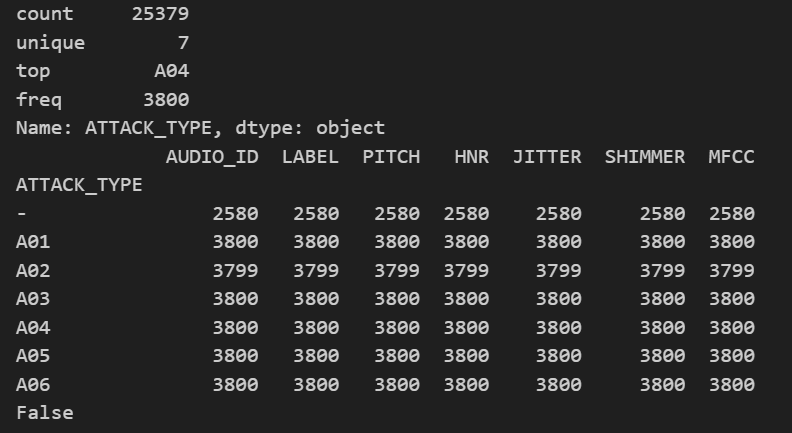

In [ ]:
dev_path = r'C:\Users\ivyap\Desktop\25SU\TEAMLAB\merged_features\merged_dev_com.pkl'
dev_df = pd.read_pickle(dev_path)
# print(dev_df['ATTACK_TYPE'].describe())
# print(dev_df.groupby('ATTACK_TYPE').count())
# print(dev_df['LABEL'].hasnans)

count     24844
unique        7
top         A03
freq       3716
Name: ATTACK_TYPE, dtype: object
             AUDIO_ID  LABEL  PITCH   HNR  JITTER  SHIMMER  MFCC
ATTACK_TYPE                                                     
-                2548   2548   2548  2548    2548     2548  2548
A01              3716   3716   3716  3716    3716     3716  3716
A02              3716   3716   3716  3716    3716     3716  3716
A03              3716   3716   3716  3716    3716     3716  3716
A04              3716   3716   3716  3716    3716     3716  3716
A05              3716   3716   3716  3716    3716     3716  3716
A06              3716   3716   3716  3716    3716     3716  3716
False


### Reminder

- There are missing feature in the testing data, need double check the audio file manually and probably add (try/except) in the testing process.
- move wandb out of TeamLab file on remote server